# Mapping Downscaled Data Products: Cal-Adapt
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Background](#caladapt)

[Load and Query the Cal-Adapt Catalog](#load)

[Read in Data](#xarray)

[Make Maps: LOCA2 vs WRF](#maps)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will work with _downscaled_ climate information from the [Cal-Adapt Analytics Engine Data Catalog](https://analytics.cal-adapt.org/data/catalog/). These data will be used to generate maps of future precipitation projections over the state of California.

Skills provided in this tutorial:
- Background on downscaling techniques (statistical versus dynamical);
- Mapping, including displaying geospatial features using shape files

### **This is the Code-Along version of tutorial 1!!** 

This notebook contains only a selected subset of the code for tutorial 1, so that it can be completed in a "code along" format in a classroom context. If you would like the fully completed version, please see "1. Mapping Downscaled Products.ipynb" in this repo.

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. This tutorial assumes that you have all the packages needed for the [Plotting Regional Time Series](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb) tutorial in the EnsembleAnalysis repo installed; if you need more details on these packages, please see that tutorial.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


<a id='caladapt'></a> 
## **Background: Cal-Adapt and Downscaling**

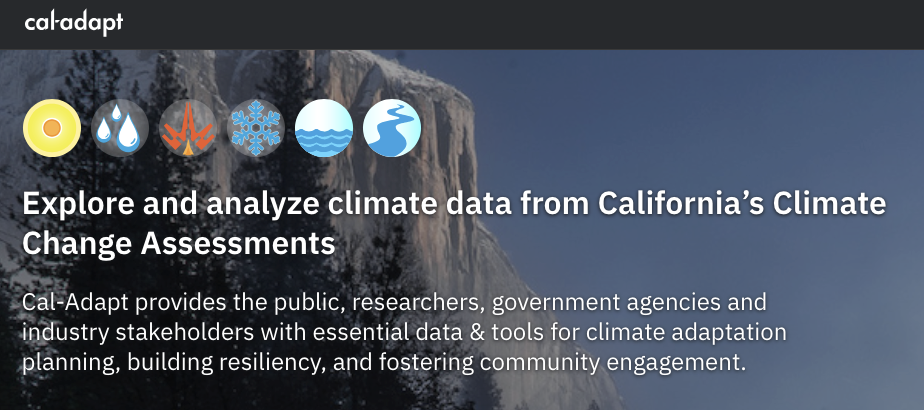

Previous tutorials have focused on working with the CMIP6 data catalog, which provides globally complete information for a variety of models. Here, we're going to learn how to work with a new database using the same cloud computing techniques we learned for CMIP6: this new database is the [Cal-Adapt Analytics Engine Data Catalog](https://analytics.cal-adapt.org/data/catalog/), built for the [Cal-Adapt project](https://cal-adapt.org/). 

### **What is Cal-Adapt?**

Cal-Adapt is a public initiative aimed at helping improve access to climate information on scales usable for climate adaptation actions in California! It's a collaboration between university researchers, the USGS, California state agencies, and other organizations. Their mission is to "make data portraying climate change in California more accessible and actionable for a broad audience, with an emphasis on energy sector stakeholders and local governments." You can read [all about the Cal-Adapt project here!](https://cal-adapt.org/about/)

For our purposes, the important things to know are:
- Cal-Adapt hosts climate data products for the state of California, including current-day observations and future projections;
- everything is free to the public and available for anyone to use;
- and they have LOTS of amazing tutorials and Web portals for accessing data! 

I highly recommend going to the Cal-Adapt website and poking around to explore all the different options - and the wealth of background information on everything they've done.


### **Downscaling: What is That?**

You'll notice when looking through the Cal-Adapt data catalog that all of their projections are _downscaled_ from larger CMIP6 climate simulations (many of which we looked at in previous tutorials). That's because Cal-Adapt is designed to be directly usable for on-the-ground planning decisions in California; but the grid spacing in CMIP6 models is very large, such that everything in a 100-200km box gets smeared out into a single number! To get around this problem, the Cal-Adapt team performed _downscaling_, or the act of taking coarse-resolution information from a global model and increasing its resolution. 

There are two major pathways by which one can accomplish downscaling:
- **Statistical**: applying statistically-derived relationships between large- and small-scale climate information to global model output;
- **Dynamical**: taking a different physical model with smaller grid spacing, and embedding it inside _boundaries_ derived from the global model.

There are a LOT of different methods for statistical and dynamical downscaling out there! Many more than would fit in a single tutorial... so I'll just describe the methods that are used in the Cal-Adapt database.

#### **Cal-Adapt Statistical Downscaling: LOCA2**

The statistical downscaling used in Cal-Adapt is the second iteration of what they call the Localized Constructed Analogs, or LOCA, method (hence, LOCA2). This is a bit of a mouthful! 

Basically, what LOCA does is to take the _large-scale_ climate patterns for every given day from a global climate model, then turn to the _observed_ climate and locate the days **in the real world** where the climate pattern best match the global model. Since observations have information on smaller spatial scales than the global model, you can then just grab that high-resolution spatial information from the real world and use it to fill in the "details" that are missing from the global model. That's the _constructed analog_ part!

Where the _local_ part comes in is that this matching is done INDEPENDENTLY over different regions of the global model. Local regions are identified based on which places are highly correlated with each other in the real world: then the matching process is done as described above for each local region, and the regions are smoothed together at the edges.

All the details you could ever want about the LOCA process are available here on the [What is LOCA?](https://loca.ucsd.edu/what-is-loca/) page maintained by David Pierce from UCSD, who developed the method.

#### **Cal-Adapt Dynamical Downscaling: WRF**

The second downscaling method used in Cal-Adapt is _dynamical downscaling_ using an atmospheric model called the Weather Research and Forecasting model, or WRF. This is a model that gets used a lot in weather forecasting, as the name implies - the idea with these types of _regional_ atmospheric models is that you can set them up over any regional _domain_ you want, at any arbitrary resolution. Then within that domain, they function basically the same way as the atmospheric component of a global model, just including processes at smaller scales! (Regional models also exist for the land and ocean, we're just not focusing on those right now).

There were three specific domains chosen for the Cal-Adapt WRF simulations, which are shown in the image below: these are _nested_ inside each other, with the grid spacing becoming smaller after each nesting _step_.

<a href="https://dept.atmos.ucla.edu/sites/default/files/alexhall/files/aws_tiers_dirstructure_nov22.pdf">
  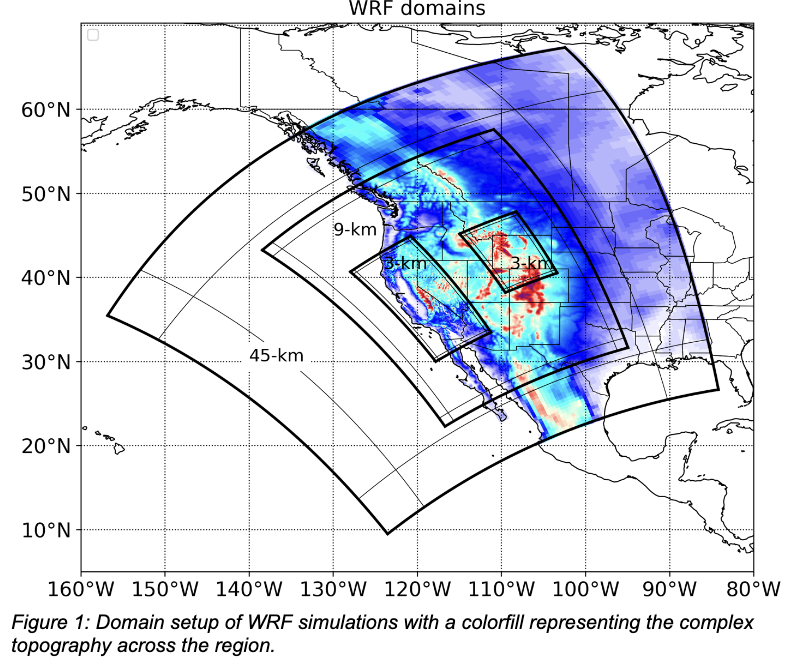
</a>

The idea behind nesting is that if you reduce the size of model grid cells TOO fast, you can actually mess things up! That's because you run the risk of introducing numerical errors related to trying to suddenly interpolate between an outside grid that's very large (say, 100km on a side) to an inside grid that's very small (say, 3km on a side). Things operate much more smoothly if you do it a little at a time. That's why in the WRF cartoon above, the grid sizes in the different nesting steps are:
- 45 km
- 9km
- 3km

Spoiler alert: those grid sizes are going to be the same ones referred to in the Cal-Adapt data catalog below as `d01`, `d02`, and `d03`!

<a id='load'></a> 
## **Load and Query the Cal-Adapt Catalog**

Now that we have some understanding of the purpose of Cal-Adapt and downscaling in general, let's take a look at the actual database!

You may also find these resources helpful to read more about the data and how it's organized:
- [Cal-Adapt Analytics Engine Data Catalog](https://analytics.cal-adapt.org/data/catalog/)

The same principles apply to accessing this data catalog as we saw for CMIP6 - we'll continue using the intake package to turn the JSON file on AWS into a data frame:

In [2]:
# Open the Cal-Adapt data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cadcat.s3.amazonaws.com/cae-collection.json')

# Print the associated data frame


### **Getting to know the data**

The formatting looks very similar to what we saw for the CMIP6 AWS holdings - in fact, a lot of the column names in the data frame are the same ones we used for CMIP6! Some examples:
- "institution_id": still means the research institution that made the model (most of them come from UC San Diego in this case)
- "source_id": still means the name of the model
- "experiment_id": still means the name of the type of simulation (historical, SSP, etc)
- "member_id": still means the name of the particular ensemble member you're using

Some of the columns have names that will look familiar, but now will have slightly different contents than they did before. Examples:
- "activity_id": instead of CMIP and ScenarioMIP, now this will say either "LOCA2" or "WRF" in reference to the downscaling technique used
- "variable_id": this is still the climate variable, but the contents are more limited than before - since these are very high-resolution datasets and there aren't as many institutions around the world contributing resources to hosting the data, they had to pick and choose just a few variables.

Finally, there are a couple new column names, some of which have similar meanings to ones we saw in the CMIP6 database. Examples:
- "path": this is the equivalent of the "zstore" column for CMIP6, it points to the location of the remote zarr store.
- "grid_label": this is a somewhat arbitrary designation that refers to the three different downscaling grids used in Cal-Adapt. The LOCA2 simulations are downscaled to 3km ("d03"), which is the same as the highest resolution used for the WRF downscaling. As mentioned above, the WRF simulations also use either 45km (over a larger domain) or 9km (over a smaller one); these are the "d01" and "d02" grids, respectively.

Let's try printing out the values of a few fields to see what they look like!

In [5]:
# Print out all unique grid labels
print(catalog.df.grid_label.unique())

# Print out all unique variable_id values
print(catalog.df.variable_id.unique())

# Print out all unique table_id values
print(catalog.df.table_id.unique())

['d03' 'd01' 'd02']
['hursmax' 'hursmin' 'huss' 'pr' 'rsds' 'tasmax' 'tasmin' 'uas' 'vas'
 'wspeed' 'lwdnbc' 'lwdnb' 'lwupbc' 'lwupb' 'prec' 'psfc' 'q2' 'rainc'
 'rainnc' 'runsb' 'runsf' 'snow' 'snownc' 'swddif' 'swdnbc' 'swdnb'
 'swupbc' 'swupb' 't2' 'tsk' 'u10' 'v10' 'etrans_sfc' 'evap_sfc' 'gh_sfc'
 'iwp' 'lh_sfc' 'lw_dwn' 'lwp' 'lw_sfc' 'prec_c' 'prec_max' 'prec_snow'
 'rh' 'sfc_runoff' 'sh_sfc' 'subsfc_runoff' 'sw_dwn' 'sw_sfc' 't2max'
 't2min' 'tskin' 'wspd10max' 'wspd10mean' 'p' 'ph' 'swddir' 'swddni' 't'
 'u' 'v' 'znt' 'cape' 'cin' 'lcl' 'lfc' 'pblh' 'rh_max' 'rh_min']
['day' 'mon' 'yrmax' '1hr']


In [9]:
# Store the data frame as its own variable
cat_df = catalog.df

# Display all the variables available at different time resolutions
# daily
print(cat_df[cat_df['table_id'] == 'day'].variable_id.unique())

# monthly
print(cat_df[cat_df['table_id'] == 'mon'].variable_id.unique())

['hursmax' 'hursmin' 'huss' 'pr' 'rsds' 'tasmax' 'tasmin' 'uas' 'vas'
 'wspeed' 'etrans_sfc' 'evap_sfc' 'gh_sfc' 'iwp' 'lh_sfc' 'lw_dwn' 'lwp'
 'lw_sfc' 'prec_c' 'prec' 'prec_max' 'prec_snow' 'psfc' 'q2' 'rh'
 'sfc_runoff' 'sh_sfc' 'snow' 'subsfc_runoff' 'sw_dwn' 'sw_sfc' 't2'
 't2max' 't2min' 'tskin' 'wspd10max' 'wspd10mean' 'cape' 'cin' 'lcl' 'lfc'
 'pblh' 'rh_max' 'rh_min' 'u10' 'v10']
['hursmax' 'hursmin' 'huss' 'pr' 'rsds' 'tasmax' 'tasmin' 'uas' 'vas'
 'wspeed' 'etrans_sfc' 'evap_sfc' 'gh_sfc' 'iwp' 'lh_sfc' 'lw_dwn' 'lwp'
 'lw_sfc' 'prec_c' 'prec' 'prec_max' 'prec_snow' 'psfc' 'q2' 'rh'
 'sfc_runoff' 'sh_sfc' 'snow' 'subsfc_runoff' 'sw_dwn' 'sw_sfc' 't2'
 't2max' 't2min' 'tskin' 'wspd10max' 'wspd10mean' 'cape' 'cin' 'lcl' 'lfc'
 'pblh']


As expected, we see that there are three unique grid labels, and that there are a bunch of different variables available! 

#### Variable names

The LOCA2 variable naming conventions in Cal-Adapt follow the "CMOR" convention used in the CMIP6 catalog. A complete list of those standard variable names can be found on the [CMIP website](https://pcmdi.llnl.gov/mips/cmip3/variableList.html). 

In case it's easier, here is a screenshot from the [Cal-Adapt data catalog](https://analytics.cal-adapt.org/data/catalog/) showing the plain English names of some of the variables as well:

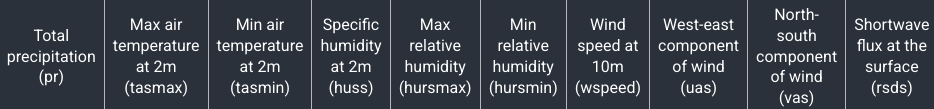

_Another tip:_ if you're ever confused about what a variable name is, you can always read in that data file into xarray, and display its contents - the plain English name will be included there! A much more detailed illustration of that is shown in the WRF section below.

### **Constructing a query: selected LOCA2 data**

Let's use the techniques we learned from the CMIP6 database to pull out some LOCA2 data and make a difference map showing future - historical changes. Just to pick something, let's extract the SSP370 data along with the corresponding historical information. We'll also stick with monthly output, just to make the code run faster.

First: display all the possible models which used LOCA2 downscaling in the first place!

In [10]:
# Specify search terms to query catalog 
# activity_id: which downscaling technique do you want?
activity_id = ['LOCA2']

# experiment_id: which historical/future scenario do you want?
experiment_ids = ['historical', 'ssp370']

# table_id: which time resolution do you want?
table_id = ['day']

# variable_id: which variable do you want?
variable_id = ['pr']

As we did in previous tutorials, we now apply the `.search` functionality to retrieve the information we want, then convert it to a data frame that we can work with:

In [12]:
# Search through catalog, store results
loca_res = catalog.search(activity_id = activity_id,
                         experiment_id = experiment_ids,
                         table_id = table_id,
                         variable_id = variable_id)

# Display data frame associated with results
display(loca_res.df)

# Display unique models 
print(loca_res.df.source_id.unique())

activity_id institution_id   source_id experiment_id member_id table_id  \
0         LOCA2           UCSD  ACCESS-CM2    historical  r1i1p1f1      day   
1         LOCA2           UCSD  ACCESS-CM2    historical  r2i1p1f1      day   
2         LOCA2           UCSD  ACCESS-CM2    historical  r3i1p1f1      day   
3         LOCA2           UCSD  ACCESS-CM2        ssp370  r1i1p1f1      day   
4         LOCA2           UCSD  ACCESS-CM2        ssp370  r2i1p1f1      day   
..          ...            ...         ...           ...       ...      ...   
127       LOCA2           UCSD  MRI-ESM2-0        ssp370  r3i1p1f1      day   
128       LOCA2           UCSD  MRI-ESM2-0        ssp370  r4i1p1f1      day   
129       LOCA2           UCSD  MRI-ESM2-0        ssp370  r5i1p1f1      day   
130       LOCA2           UCSD     TaiESM1    historical  r1i1p1f1      day   
131       LOCA2           UCSD     TaiESM1        ssp370  r1i1p1f1      day   

    variable_id grid_label                                               path  
0            pr        d03  s3://cadcat/loca2/ucsd/access-cm2/historical/r...  
1            pr        d03  s3://cadcat/loca2/ucsd/access-cm2/historical/r...  
2            pr        d03  s3://cadcat/loca2/ucsd/access-cm2/historical/r...  
3            pr        d03  s3://cadcat/loca2/ucsd/access-cm2/ssp370/r1i1p...  
4            pr        d03  s3://cadcat/loca2/ucsd/access-cm2/ssp370/r2i1p...  
..          ...        ...                                                ...  
127          pr        d03  s3://cadcat/loca2/ucsd/mri-esm2-0/ssp370/r3i1p...  
128          pr        d03  s3://cadcat/loca2/ucsd/mri-esm2-0/ssp370/r4i1p...  
129          pr        d03  s3://cadcat/loca2/ucsd/mri-esm2-0/ssp370/r5i1p...  
130          pr        d03  s3://cadcat/loca2/ucsd/taiesm1/historical/r1i1...  
131          pr        d03  s3://cadcat/loca2/ucsd/taiesm1/ssp370/r1i1p1f1...  

[132 rows x 9 columns]

['ACCESS-CM2' 'CESM2-LENS' 'CNRM-ESM2-1' 'EC-Earth3' 'EC-Earth3-Veg'
 'FGOALS-g3' 'GFDL-ESM4' 'HadGEM3-GC31-LL' 'INM-CM5-0' 'IPSL-CM6A-LR'
 'KACE-1-0-G' 'MIROC6' 'MPI-ESM1-2-HR' 'MRI-ESM2-0' 'TaiESM1']


As you can see from the above query, there are quite a few models which used the LOCA2 downscaling methodology and generated historical and SSP3-7.0 simulations. 

We'll pick one of these for our mapping exercise: let's say the CESM2-LENS.

### **Constructing a query: selected WRF data**

Our goal today is to look at how different downscaling techniques lead to different outcomes. Let's change our catalog query terms slightly, to look at the WRF downscaling simulations rather than LOCA2 for a bit. We'll keep the "experiment_ids" from the previous query, since we want to be comparing the same scenarios to one another!

In [13]:
# Specify search terms to query catalog 
# activity_id: which downscaling technique do you want?
activity_id = ['WRF']

In [15]:
# Search through catalog, store results
wrf_res = catalog.search(activity_id = activity_id,
                         experiment_id = experiment_ids,
                         table_id = table_id)

# Display data frame associated with results
display(wrf_res.df)

activity_id institution_id  source_id experiment_id  member_id table_id  \
0            WRF           UCLA      CESM2    historical  r11i1p1f1      day   
1            WRF           UCLA      CESM2    historical  r11i1p1f1      day   
2            WRF           UCLA      CESM2    historical  r11i1p1f1      day   
3            WRF           UCLA      CESM2    historical  r11i1p1f1      day   
4            WRF           UCLA      CESM2    historical  r11i1p1f1      day   
...          ...            ...        ...           ...        ...      ...   
1517         WRF           UCSD  FGOALS-g3        ssp370   r1i1p1f1      day   
1518         WRF           UCSD  FGOALS-g3        ssp370   r1i1p1f1      day   
1519         WRF           UCSD  FGOALS-g3        ssp370   r1i1p1f1      day   
1520         WRF           UCSD  FGOALS-g3        ssp370   r1i1p1f1      day   
1521         WRF           UCSD  FGOALS-g3        ssp370   r1i1p1f1      day   

     variable_id grid_label                                               path  
0     etrans_sfc        d01  s3://cadcat/wrf/ucla/cesm2/historical/day/etra...  
1     etrans_sfc        d02  s3://cadcat/wrf/ucla/cesm2/historical/day/etra...  
2     etrans_sfc        d03  s3://cadcat/wrf/ucla/cesm2/historical/day/etra...  
3       evap_sfc        d01  s3://cadcat/wrf/ucla/cesm2/historical/day/evap...  
4       evap_sfc        d02  s3://cadcat/wrf/ucla/cesm2/historical/day/evap...  
...          ...        ...                                                ...  
1517       t2max        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  
1518       t2min        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  
1519         u10        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  
1520         v10        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  
1521  wspd10mean        d03  s3://cadcat/wrf/ucsd/fgoals-g3/ssp370/r1i1p1f1...  

[1522 rows x 9 columns]

#### **Matching model names**

Again, there's a lot going on here. Let's figure out what the model names are, since they might not be specified exactly the same way as the LOCA2 ones were:

In [17]:
# Display unique models 
print(wrf_res.df.source_id.unique())

# Compare them with the LOCA2 model list
print(loca_res.df.source_id.unique())

['CESM2' 'CNRM-ESM2-1' 'EC-Earth3' 'EC-Earth3-Veg' 'FGOALS-g3' 'MIROC6'
 'MPI-ESM1-2-HR' 'TaiESM1']
['ACCESS-CM2' 'CESM2-LENS' 'CNRM-ESM2-1' 'EC-Earth3' 'EC-Earth3-Veg'
 'FGOALS-g3' 'GFDL-ESM4' 'HadGEM3-GC31-LL' 'INM-CM5-0' 'IPSL-CM6A-LR'
 'KACE-1-0-G' 'MIROC6' 'MPI-ESM1-2-HR' 'MRI-ESM2-0' 'TaiESM1']


Notice that SOME of the model names ARE identical between the WRF and LOCA2 set! We just happened to pick one that's slightly different:
- LOCA2: source_id is called `CESM2-LENS`
- WRF: source_id is called `CESM2`

_What's the difference?_

This is just a terminology thing! "LENS" is the abbreviation for "large ensemble", and "CESM2-LENS" is the set of large ensemble simulations that were run using CESM2. More information on the CESM2 LENS can be found [here](https://www.cesm.ucar.edu/community-projects/lens2). But the point is: "CESM2" and "CESM2-LENS" can be used interchangeably!

#### **Matching variable names**

OK now we've figured out the WRF name for CESM2-LENS: `CESM2`. Let's make sure we've also got a comparable variable!

In [18]:
# Display unique variables 
print(wrf_res.df.variable_id.unique())

['etrans_sfc' 'evap_sfc' 'gh_sfc' 'iwp' 'lh_sfc' 'lw_dwn' 'lwp' 'lw_sfc'
 'prec_c' 'prec' 'prec_max' 'prec_snow' 'psfc' 'q2' 'rh' 'sfc_runoff'
 'sh_sfc' 'snow' 'subsfc_runoff' 'sw_dwn' 'sw_sfc' 't2' 't2max' 't2min'
 'tskin' 'wspd10max' 'wspd10mean' 'cape' 'cin' 'lcl' 'lfc' 'pblh' 'rh_max'
 'rh_min' 'u10' 'v10']


As you can see, the variable names from WRF are different from those for LOCA2, and from the CMIP6 conventions. In order to make sure that we're looking at a comparable variable in WRF vs LOCA2, we can use the following approach to examine the plain English name associated with the WRF variables.

We know that we're interested in looking at precipitation, which is called `pr` in LOCA2. The variable names that seem similar in the list above are:
- prec
- psfc
- prec_c
- prec_max
- prec_snow

Let's read in one of these files and display the associated metadata using xarray's ability to do this!

In [19]:
# Extract the CESM2 data in the WRF catalog data frame
cesm2_wrf_df = wrf_res.df[(wrf_res.df["source_id"] == "CESM2")]

# Extract the "prec" data field from the CESM2 data frame                          
prec_cesm2df = cesm2_wrf_df[(cesm2_wrf_df["variable_id"] == "prec")]

# Print results
print(prec_cesm2df)

     activity_id institution_id source_id experiment_id  member_id table_id  \
26           WRF           UCLA     CESM2    historical  r11i1p1f1      day   
27           WRF           UCLA     CESM2    historical  r11i1p1f1      day   
28           WRF           UCLA     CESM2    historical  r11i1p1f1      day   
106          WRF           UCLA     CESM2        ssp370  r11i1p1f1      day   
107          WRF           UCLA     CESM2        ssp370  r11i1p1f1      day   
108          WRF           UCLA     CESM2        ssp370  r11i1p1f1      day   
1442         WRF           UCSD     CESM2    historical  r11i1p1f1      day   
1452         WRF           UCSD     CESM2        ssp370  r11i1p1f1      day   

     variable_id grid_label                                               path  
26          prec        d01  s3://cadcat/wrf/ucla/cesm2/historical/day/prec...  
27          prec        d02  s3://cadcat/wrf/ucla/cesm2/historical/day/prec...  
28          prec        d03  s3://cadcat/wrf/

Again there's a lot going on here - let's ignore most of it for now and just read in data from the first entry to see what the variable name means!

Below I've used the `iloc[]` syntax to display the first entry in the `['path']` field:

In [21]:
# Read in first entry, display metadata
test_data = xr.open_zarr(prec_cesm2df['path'].iloc[0], storage_options={'anon': True})

Now we want to get the English name of the variable! This is stored in the "attributes" of the variable DataArray. To get at it, display the prec array:

In [22]:
# Display the contents of the "prec" variable
test_data.prec

<xarray.DataArray 'prec' (time: 12410, y: 104, x: 109)>
dask.array<open_dataset-a28b8a4cfe2fb1201b51bb2f4c294a2eprec, shape=(12410, 104, 109), dtype=float32, chunksize=(6061, 72, 76), chunktype=numpy.ndarray>
Coordinates:
    Lambert_Conformal  int32 ...
    lakemask           (y, x) float32 dask.array<chunksize=(72, 76), meta=np.ndarray>
    landmask           (y, x) float32 dask.array<chunksize=(72, 76), meta=np.ndarray>
    lat                (y, x) float32 dask.array<chunksize=(72, 76), meta=np.ndarray>
    lon                (y, x) float32 dask.array<chunksize=(72, 76), meta=np.ndarray>
  * time               (time) datetime64[ns] 1980-09-01 ... 2014-08-31
  * x                  (x) float64 -6.285e+06 -6.24e+06 ... -1.47e+06 -1.425e+06
  * y                  (y) float64 -1.126e+06 -1.081e+06 ... 3.464e+06 3.509e+06
Attributes:
    grid_mapping:  Lambert_Conformal
    long_name:     precipitation
    units:         mm/d

Now we can officially see - yes, `prec` in WRF is indeed total precipitation! That means it's directly comparable to the LOCA2 `pr` variable.

You can try the same thing with one of the other precipitation variables from the list above to see what they look like! 

This is a really useful thing to keep in mind if you're ever confused about what variable you're looking at: there will always be metadata in the file itself that will tell you what it is. So if you can't find a complete list provided elsewhere, trust in the netCDF!

<a id='xarray'></a> 
## **Read in Data**

Now we can read in the zarr stores containing the actual information. This will use the same approach we applied in previous tutorials, such as [Plotting Multiple Ensemble Members](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/1.%20Plotting%20Multiple%20Ensemble%20Members.ipynb): we'll read in all ensemble members, concatenate the historical and SSP portions, add them to a list, and concatenate the whole thing together while storing the ensemble member names.

### **LOCA2**

First, let's go through the process for the LOCA2 information!

In [23]:
# Subset the LOCA2 data frame to use only the CESM2 information
loca_df = loca_res.df

# CESM2 historical
cesm2_loca_histdf = loca_df[(loca_df["source_id"] == "CESM2-LENS") & (loca_df["experiment_id"] == "historical")]

# CESM2 SSP3-7.0
cesm2_loca_sspdf = loca_df[(loca_df["source_id"] == "CESM2-LENS") & (loca_df["experiment_id"] == "ssp370")]


In [24]:
# Make a list of the unique ensemble members
# historical
mems_hist = cesm2_loca_histdf.member_id.unique()
# SSP
mems_ssp = cesm2_loca_sspdf.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

print(common_mems)


['r1i1p1f1', 'r9i1p1f1', 'r4i1p1f1', 'r3i1p1f1', 'r7i1p1f1', 'r8i1p1f1', 'r6i1p1f1', 'r2i1p1f1', 'r5i1p1f1', 'r10i1p1f1']


In [25]:
# Define an empty list
cesm2_loca_data = []

# Loop over all common ensemble members
for mem in range(len(common_mems)):
    print(common_mems[mem])

    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = cesm2_loca_histdf['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = cesm2_loca_histdf['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = cesm2_loca_sspdf['member_id'] == common_mems[mem]
    ssp_loc = cesm2_loca_sspdf['member_id'][ssp_mask].index[0]
    
    # Store HISTORICAL data as xarray
    hist_data = xr.open_zarr(cesm2_loca_histdf['path'][hist_loc], storage_options={'anon': True})
    
    # Store SSP3-7.0 data as xarray
    ssp_data = xr.open_zarr(cesm2_loca_sspdf['path'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate historical, SSP information
    temp_data = xr.concat([hist_data, ssp_data], dim="time")
    
    # Add to list
    cesm2_loca_data.append(temp_data)

# Concatenate the list into a single xarray object
cesm2_loca_data = xr.concat(cesm2_loca_data, dim="member")

# Store the actual member information as values of the new dimension
cesm2_loca_data = cesm2_loca_data.assign_coords(member=("member", common_mems))

r1i1p1f1
r9i1p1f1
r4i1p1f1
r3i1p1f1
r7i1p1f1
r8i1p1f1
r6i1p1f1
r2i1p1f1
r5i1p1f1
r10i1p1f1


In [26]:
# Print xarray object
print(cesm2_loca_data)

<xarray.Dataset>
Dimensions:  (lat: 495, lon: 559, member: 10, time: 55152)
Coordinates:
  * lat      (lat) float32 29.58 29.61 29.64 29.67 ... 44.92 44.95 44.98 45.02
  * lon      (lon) float32 -128.4 -128.4 -128.4 -128.3 ... -111.0 -111.0 -111.0
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 2100-12-31T12:00:00
  * member   (member) <U9 'r1i1p1f1' 'r9i1p1f1' ... 'r5i1p1f1' 'r10i1p1f1'
Data variables:
    pr       (member, time, lat, lon) float32 dask.array<chunksize=(1, 1697, 123, 139), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                         CF-1.0
    ID_loca_routines_module:             $Id: loca_routines_module.F90,v 1.13...
    NCO:                                 4.6.7
    SIOCRD_netCDF_Version:               1.0
    SOURCE_loca_routines_module:         $Source: /home6/dwpierc2/src/mine/lo...
    bias_correction:                     downscaling via PresRat, Pierce et a...
    ...                                  ...
    opts_var_type:           

### **WRF**

Now we do exactly the same thing for the WRF data. Since we know more about what we want now, let's redo the catalog query with additional search terms: note that in addition to the terms discussed above, I've also added a new one for `institution_id`. That's because for this particular set of simulations, both UCLA and UCSD generated their own estimates of 3km WRF downscaling - to make things simpler, we'll just pick one to look at.

In [27]:
# Reset search fields
activity_id = ["WRF"]
table_id = ["day"]

# Source ID: CESM2
source_id = ["CESM2"]

# Precipitation variable from WRF
variable_id = ["prec"]

# Domain/downscaling level: 3km (d03)
grid_label = ["d03"]

# Institution ID
institution_id = ['UCSD']

# New query
# Historical
wrf_hist_res = catalog.search(activity_id=activity_id, experiment_id="historical", source_id = source_id,
                     table_id=table_id, variable_id=variable_id, grid_label=grid_label, institution_id=institution_id)
# SSP370
wrf_ssp_res = catalog.search(activity_id=activity_id, experiment_id="ssp370", source_id = source_id,
                     table_id=table_id, variable_id=variable_id, grid_label=grid_label, institution_id=institution_id)

In [28]:
# Save data frame
cesm2_wrf_histdf = wrf_hist_res.df
cesm2_wrf_sspdf = wrf_ssp_res.df

display(cesm2_wrf_histdf)

activity_id institution_id source_id experiment_id  member_id table_id  \
0         WRF           UCSD     CESM2    historical  r11i1p1f1      day   

  variable_id grid_label                                               path  
0        prec        d03  s3://cadcat/wrf/ucsd/cesm2/historical/r11i1p1f...

In [29]:
# Define an empty list
cesm2_wrf_data = []

# Loop over all common ensemble members
for mem in cesm2_wrf_histdf.member_id:
    print(mem)

    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = cesm2_wrf_histdf['member_id'] == mem
    # extract (first) location where the mask is True
    hist_loc = cesm2_wrf_histdf['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = cesm2_wrf_sspdf['member_id'] == mem
    ssp_loc = cesm2_wrf_sspdf['member_id'][ssp_mask].index[0]
        
    # Store HISTORICAL data as xarray
    hist_data = xr.open_zarr(cesm2_wrf_histdf['path'][hist_loc], storage_options={'anon': True})
    
    # Store SSP3-7.0 data as xarray
    ssp_data = xr.open_zarr(cesm2_wrf_sspdf['path'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate historical, SSP information
    temp_data = xr.concat([hist_data, ssp_data], dim="time")
    
    # Add to list
    cesm2_wrf_data.append(temp_data)

# Concatenate the list into a single xarray object
cesm2_wrf_data = xr.concat(cesm2_wrf_data, dim="member")

# Store the actual member information as values of the new dimension
cesm2_wrf_data = cesm2_wrf_data.assign_coords(member=("member", cesm2_wrf_histdf.member_id))

r11i1p1f1


<a id='maps'></a> 
## **Make Maps: LOCA2 vs WRF**

After all that, we finally have our xarray datasets containing ensemble precipitation information for both the LOCA2 and WRF-downscaled versions of the CESM2 information! Hooray!

Now let's actually do something with that data...

We can use the mapping techniques we learned in previous tutorials to visualize the epoch differences between an earlier and later time period. For the California Fifth Climate Change Assessment, the recommended time periods for analysis are:
- Historical: 1981-2010
- Mid-century: 2041-2070
- Late-century: 2071-2100

Let's take a look at the difference between the late-century and historical periods, where we expect the largest differences to be present.

In [ ]:
# Get data for an earlier period

# Get data for a later period

# Calculate the differences


In [ ]:
# Calculate the ensemble means


### **Extract values, convert units**

To make the code run a bit faster, we'll do our trick from previous tutorials of saving out the values from the `cesm2_loca_diff` and `cesm2_wrf_diff` datasets as Numpy arrays - this will be quite slow, but then the plotting step will run fast afterwards! This is a nice feature for times when you might want to fiddle with the plot's appearance and don't want to go through the process of re-extracting all the numbers from the xarray dataset every time you change something about the plot.

In [ ]:
# Extract LOCA2 values into a Numpy array

# Extract WRF values into a Numpy array


We also want to make sure that the **units** of the data are the same for both datasets! We can first see what they are for LOCA2 and WRF:

In [ ]:
# Display units for LOCA2, WRF data



The units for LOCA2 are kg/m^2/s, but WRF is shown in mm/day. Since mm/day is a more intuitive unit, let's use that one for both datasets:

In [ ]:
# Convert LOCA2 values to mm/day


Now let's see what everything looks like!

In [ ]:

# Make a figure with two subplots

# Subplot 1: LOCA2

# Add coastlines, state borders, and gridlines

# Add colorbar

# Subplot 2: WRF

# Add coastlines, state borders, and gridlines

# Add colorbar


The overall changes are similar between LOCA2 and WRF, but there are some important differences. Changes in the precipitation over mountain regions seem to be higher in WRF, for instance; this is probably because WRF is a dynamical model, which doesn't have as many issues with underestimating extremes as LOCA2. Note: if this sounds a little speculative, it's because trying to interpret these features can be quite difficult! For a detailed discussion of tradeoffs between LOCA2 and WRF, see the [Cal-Adapt Guidance on Using Climate Data in Decision-Making](https://analytics.cal-adapt.org/guidance/using_in_decision_making/) - there's a lot to consider.

#### **Beautify the figure using shape files**

As a final touch, we can add some geospatial features to these plots using shape files! For the California Fifth Climate Change Assessment, many of the results are reported by county across the state. So let's add shape files for the county boundaries - these can be found [online](https://data.ca.gov/dataset/ca-geographic-boundaries), but have also been uploaded to the present repo in the 'ca_counties' subdirectory.

We already saw the process for masking based on shape files in the [Plotting Regional Data Using Shape Files](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb) and others in that repository; we'll continue using Geopandas to add things to our figure here. We don't need to do any masking, so this is actually easier than what we were doing before!

In [ ]:
# Read in shapefile for CA counties

# Reproject the shapefile to use the PlateCarree projection


In [ ]:

# Make a figure with two subplots

# Subplot 1: LOCA2

# Add coastlines, borders, and gridlines

# Add colorbar

# Add county shape file

# Subplot 2: WRF

# Add coastlines, borders, and gridlines

# Add colorbar

# Add county shape file




Now you can clearly identify the differences between precipitation projections over individual California counties!

We'll learn more about how to display additional data in the next set of tutorials.